In this script, a working example of how to explore how the SMRT function works with optimal estimation (an inverse probalistic problem solver) is shown. In the script a simple media construction of 3 snow and 2 ice layers is used for the SMRT module. This construction is not based on any theoretical model, but rather is chosen based on the parameters that were avaible to me from a MEML-simulation. The frequencies that will be analyzed will be [6.9, 10.7, 18.7, 23.8, 36.5, 50.0, 89.0, 157.0, 183.0] GHz. This is only done for first year ice, as multi year ice proved much harder to retrieve decent results for. 

To start off, let's initialize the SMRT module and import packages. To initialize the SMRT module, see https://smrt-model.science/getstarted.html.

In [1]:
import time; start_script = time.time()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyOptimalEstimation as pyOE
import scipy.stats as stats
import os, sys
path = os.getcwd()
path = os.path.abspath(os.path.join(path, os.pardir))
os.chdir(path)
sys.path.append(path)
sys.path.append(f"{path}/smrt")
from smrt import make_model, sensor_list, PSU
# from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
# from smrt import SMRTError 
import forwards_FYI
from matplotlib import cm
import seaborn as sn


Now that the modules have been initialized, the MEML-data that has been simulated for 2 different locations is loaded. This is done in order to obtain a covariance matrix for the parameters that is necessary for the optimal estimation. Brightness temperature covariance matrix is also required, but for now no correlation between different frequency channels is assumed (this is very empirically, as when the brightness temperature covariance was used, the results were significantly worse.)

Furthermore, a log transformation on some of the parameters is enabled. This is done in order to make sure that the parameters don't become negative. Furthermore, it has been shown that this transformation doesn't have a big impact on the normality of the data.

The parameters used for optimal estimation are: snow thickness, ice thickness, surface temperature, ACL avg and ACL up.

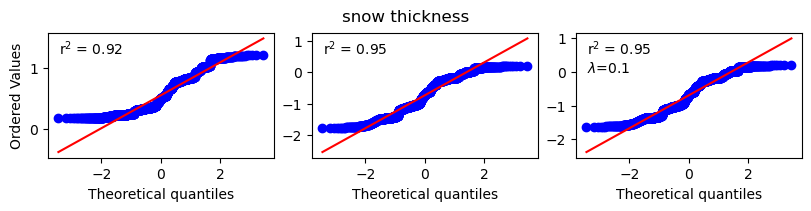

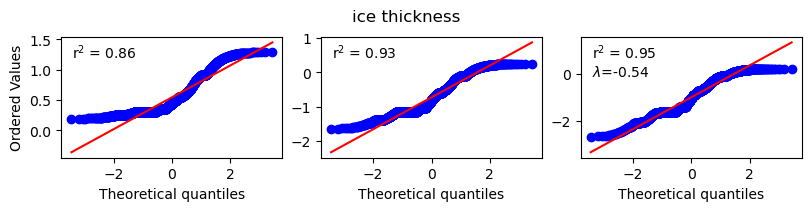

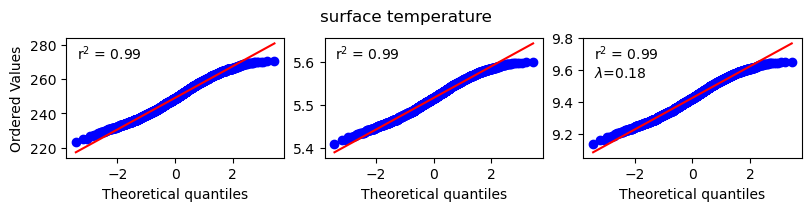

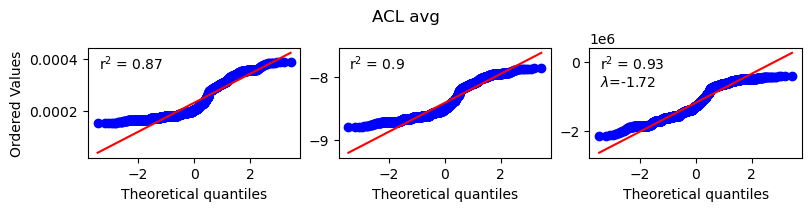

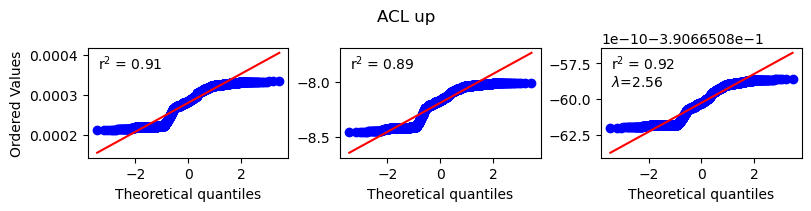

In [2]:
# Load the data
fy_sal1 = np.array(pd.read_csv('new_data/firstyearice1/emipar12.qaan',delimiter=" "))
fy_sal2 = np.array(pd.read_csv('new_data/firstyearice2/emipar12.qaan',delimiter=" "))

# Load data from all the first first year ice
Tb_all1 = fy_sal1[200:1000, 18:36].astype(float); Tb_all2 = fy_sal2[200:1000, 18:36].astype(float)
ACL_avg1 = fy_sal1[200:1000, 11]*1e-3; ACL_avg2 = fy_sal2[200:1000, 11]*1e-3 # [m]
ACL_up1 = fy_sal1[200:1000, 9]*1e-3; ACL_up2 = fy_sal2[200:1000, 9]*1e-3 # [m]
snow_thicknesses1 = fy_sal1[200:1000, 4]; snow_thicknesses2 = fy_sal2[200:1000, 4]
thick_upper_layer1 = fy_sal1[200:1000, 6]; thick_upper_layer2 = fy_sal2[200:1000, 6]
ice_thicknesses1 = fy_sal1[200:1000, 5]; ice_thicknesses2 = fy_sal2[200:1000, 5]     
surf_temps1 = fy_sal1[200:1000, 8]; surf_temps2 = fy_sal2[200:1000, 8]
snow_avg_temp1 = fy_sal1[200:1000, 12]; snow_avg_temp2 = fy_sal2[200:1000, 12]
snow_density1 = fy_sal1[200:1000, 10]; snow_density2 = fy_sal2[200:1000, 10]
snow_density_up1 = fy_sal1[200:1000, 7]; snow_density_up2 = fy_sal2[200:1000, 7]
ice_sal1 = fy_sal1[200:1000, 13]; ice_sal2 = fy_sal2[200:1000, 13]
ice_temp1 = fy_sal1[200:1000, 14]; ice_temp2 = fy_sal2[200:1000, 14]

# Initialize the parameter covariance parameters
x_vars = ['snow thickness', 'ice thickness', 'surface temperature', 'ACL avg', 'ACL up']
y_vars = ["6V", "6H", "10V", "10H", "18V", "18H", "23V", "23H", "36V", "36H", "50V", "50H","89V", "89H", "157V", "157H", "183V", "183H"] 
Y_matrix = np.concatenate((Tb_all1,Tb_all2), axis=0).T
X_matrix =  np.array([
                    np.append(snow_thicknesses1, snow_thicknesses2), 
                    np.append(ice_thicknesses1, ice_thicknesses2), 
                    np.append(surf_temps1, surf_temps2), 
                    np.append(ACL_avg1, ACL_avg2),
                    np.append(ACL_up1, ACL_up2)
                    ])    

# Include a dataset generated on the antarctis
ross_dataset = np.array(pd.read_csv('new_data/ross/emipar12.qaan',delimiter=" "))
Tb_all_ross = ross_dataset[200:1000, 18:36].astype(float)
ACL_avg_ross = ross_dataset[200:1000, 11]*1e-3
ACL_up_ross = ross_dataset[200:1000, 9]*1e-3
snow_thicknesses_ross = ross_dataset[200:1000, 4]
thick_upper_layer_ross = ross_dataset[200:1000, 6]
ice_thicknesses_ross = ross_dataset[200:1000, 5]     
surf_temps_ross = ross_dataset[200:1000, 8]
snow_avg_temp_ross = ross_dataset[200:1000, 12]
snow_density_ross = ross_dataset[200:1000, 10]
snow_density_up_ross = ross_dataset[200:1000, 7]
ice_sal_ross = ross_dataset[200:1000, 13]
ice_temp_ross = ross_dataset[200:1000, 14]
# Create the Y and X matrices for all datasets including Ross
Y_matrix_ross = np.concatenate((Tb_all1, Tb_all2, Tb_all_ross), axis=0).T
ross_matrix_X_temp = np.array([snow_thicknesses_ross, ice_thicknesses_ross, surf_temps_ross, ACL_avg_ross, ACL_up_ross]).astype(float)
X_matrix_ross = np.concatenate((X_matrix[0:5], ross_matrix_X_temp), axis=1)

# To decide whether or not the antarctic point should be used or not, lets see if the normality of the dataset is affected
X_matrix_used = X_matrix_ross
Y_matrix_used = Y_matrix_ross # Remember that the X and Y matrices have to come from the same dataset!


# Examine different transformations
for i in range(X_matrix_used.shape[0]):
    fig, ax = plt.subplots(ncols=3, figsize=(8, 2), layout='constrained')
    fig.suptitle(f'{x_vars[i]}')
    (_,_), (_,_,r0) = stats.probplot(X_matrix_used[i,:], sparams=(), dist='norm', fit=True, plot=ax[0], rvalue=False)
    (_,_), (_,_,r1) = stats.probplot(np.log(X_matrix_used[i,:]), sparams=(), dist='norm', fit=True, plot=ax[1], rvalue=False)
    (_,_), (_,_,r2) = stats.probplot(stats.boxcox(X_matrix_used[i,:])[0], sparams=(), dist='norm', fit=True, plot=ax[2], rvalue=False)
    ax[0].text(0.05, 0.95, f"r$^2$ = {np.round(r0**2,2)}", horizontalalignment='left', verticalalignment='top', transform=ax[0].transAxes)
    ax[1].text(0.05, 0.95, f"r$^2$ = {np.round(r1**2,2)}", horizontalalignment='left', verticalalignment='top', transform=ax[1].transAxes)
    ax[2].text(0.05, 0.95, f"r$^2$ = {np.round(r2**2,2)} \n$\lambda$={np.round(stats.boxcox(X_matrix_used[i,:])[1],2)}", horizontalalignment='left', verticalalignment='top', transform=ax[2].transAxes)
    ax[0].set_title('')
    ax[1].set_title('')
    ax[2].set_title('')
    ax[1].set_ylabel('')
    ax[2].set_ylabel('')
    
#     print(stats.boxcox(X_matrix[i,:])[1])
#     plt.savefig(f"paper_figures/normality_of_data{i}.png")

From this plot, we can transform our data to make the distribution as normal as possible. For the sake of simplicity, the Box-Cox transformation is not considered. The choice is therefore between no transformation or log transformation. In this regard, the normality of the parameters are pretty much unaffected by the log transformation, except for the ice thickness which becomes quite a bit more normalized. 

Besides normality, there is another reason to use a log transform on the parameters that are fed to optimal estimation. The reason being the model isn't restricted to only using positive values. For the SMRT model, negative autocorrelation lengths or snow & ice thicknesses aren't realistic and the model will break if optimal estimation points at a negative solution. This can however be avoided if a log transform is used, as negative logarithmic numbers are positive after being mapped back to raw numbers. 

With this in mind, all parameters will be log transformed except for temperature

In [3]:
logMask = (np.array([1,1,0,1,1]) == 1) # Shows where the log transform has been used

# When the transformation chosen is defined, then the covariance matrix can be defined
X_matrix_used[logMask] = np.log(X_matrix_used[logMask])
x_cov_used = np.cov(X_matrix_used)
# The covariance matrix for brightness temperature is still identity matrix
y_cov = np.eye(Y_matrix.shape[0])*(10**2)


Now the SMRT model that is going to be used to simulate the brightness temperatures based on the parameters is going to be defined. This model is the one that is going to be fed to the optimal estimation module. More context on how the exact model is defined follows.

In [4]:
freqs = np.array([6.9, 10.7, 18.7, 23.8, 36.5, 50.0, 89.0, 157.0, 183.0])*1e9 # Hz
radiometer = sensor_list.passive(frequency = freqs, theta=55)
m_32_streams = make_model("iba", "dort", rtsolver_options ={"n_max_stream": 32, "phase_normalization": "forced"})
def forward_32_streams(X):
    return forwards_FYI.forward_manualACL(X, freqs, m_32_streams, radiometer, logMask=logMask)

Now the forwards_FYI.forward_manualACL function is going to be explained (see code below markdown), but first I will explain the model and then my thoughts and considerations for the SMRT model as presented.

The model medium consists of snow and ice. The snow layer was divided into 3 layers. The first layer is set to be 5 cm deep and then the remianing 2 layers had the remaining snow thickness split between them. This implementation was chosen because the MEML simulation had data for the wind slap layer and then data averaged over the whole snowpack. Furthermore, it is important that the model is continuous to ensure that optimal estimation doesn't get stuck on a diverging parameter. 
In the ice medium, the model has 2 layers. The first layer is set to be 10 cm deep and the other layer has the remaining ice thickness. The first ice layer actually has a big impact on the brightness temperatures across all frequencies. I have a pretty good suspicion that this is very highly correlated to the salinity of the first ice layer.

To make the model converge, a lot of transformations on the data given by the MEML simulations were explored and some used. 

The way that the layers are constructed has a huge impact on how the brightness temperatures are estimated and the parameters that are necessary for creating a good brightness temperature. To generate a good retreival of the parameters, I suspect that a good snow and ice construction is very important and a good research quantity time will be needed to be spent here, unless paramater transformations like used in this media construction is used.

Below is the forward_manualACL function that the forward model for optimal estimation is based on.

In [5]:
def forward_manualACL(X, freqs, m, radiometer_low, logMask = np.array([False, False, False, False, False]), ACL_factors=[0.2, 0.5, 2], 
                      ice_split=5, ice_sal_factors = [2, 1], snow_split_low=5, density_offset = [0,0,0]):
    X[logMask] = np.exp(X[logMask]) 
    [snow_thickness, ice_thickness, surface_temp, ACL_avg, ACL_up] = X

    num, di, Ti, Wi, roi, pci, Sal, _, si = smrt_profile(snow_thickness, ice_thickness, surface_temp, 'firstyear')
    " Input is snow thickness [m], ice thickness [m], temperature of the surface, icetype: ['firstyear'/'multiyear']"
    # Output is:
    # num is the id of the layer
    # di is the layer thickness (1 cm always)
    # Ti is the thermometric temperature of each layer
    # Wi is the water content in the snow
    # roi is density through the layers
    # pci is the ACL in mm 
    # Sal is the salinity
    # typei is the type of snow or ice, where 
    # si is the snow ice interface   
    

    " snow: "
    thickness_snow = di[si == 0] + (snow_thickness%0.01)/np.sum(si == 0)   # [m]
    density_snow = roi[si == 0]     # [kg/m^3]
    ACL_snow = pci[si == 0]*1e-3    # [m]    
    temp_snow = Ti[si == 0]         # [K]
    # sal_snow = Sal[si == 0]*0.6     # ?? [g/kg] ??
    
    # snow_split = int(np.size(thickness_snow)/2)
    # thickness_snow = np.array([thickness_snow[0:snow_split].sum(), thickness_snow[snow_split:].sum()])
    # density_snow = np.array([density_snow[0:snow_split].mean(), density_snow[snow_split:].mean()])
    # ACL_snow = np.array([ACL_snow[0:snow_split].mean(), ACL_snow[snow_split:].mean()])
    # temp_snow = np.array([temp_snow[0:snow_split].mean(), temp_snow[snow_split:][:].mean()])
    # sal_snow = np.array([sal_snow[0:snow_split].mean(), sal_snow[snow_split:][:].mean()])

    if np.sum(thickness_snow) >= 2*snow_split_low*1e-2:
        snow_split_low = snow_split_low
        snow_split_high = int(snow_split_low+(snow_thickness*100-snow_split_low)/2)
    else:
        snow_split_low = int(0.5*snow_thickness*100)
        snow_split_high = int(snow_split_low+(snow_thickness*100-snow_split_low)/2)
    
    thickness_snow = np.array([thickness_snow[0:snow_split_low].sum(), 
                                    thickness_snow[snow_split_low:snow_split_high].sum(), 
                                    thickness_snow[snow_split_high:].sum()])
    density_snow = np.array([density_snow[0:snow_split_low].mean(), 
                                density_snow[snow_split_low:snow_split_high].mean(),  
                                density_snow[snow_split_high:].mean()]) + density_offset
    # density_snow[:]=density_offset+np.array([400, 400, 400])
    # print(density_snow)
    ACL_snow = ACL_factors*np.array([ACL_up,
                                    ACL_avg, 
                                    ACL_avg])
    temp_snow = np.array([temp_snow[0:snow_split_low].mean(), 
                                temp_snow[snow_split_low:snow_split_high][:].mean(), 
                                temp_snow[snow_split_high:][:].mean()])
    # sal_snow = np.array([sal_snow[0:snow_split_low].mean(), 
    #                             sal_snow[snow_split_low:snow_split_high][:].mean(), 
    #                             sal_snow[snow_split_high:][:].mean()])
    # Change the upper layer ACL of the snow, to the one decided by the model
    # ACL_snow[0] = ACL_up
    # print(thickness_snow)


    # Create the media
    snowpack = make_snowpack(thickness= thickness_snow,
                            density=    density_snow,
                            temperature=temp_snow,
                            corr_length=ACL_snow,
                            interface = 'flat',
                            surface='flat',
                            microstructure_model="exponential") 


    "Ice:"
    ice_thickness = di[si==1] + (ice_thickness%0.01)/np.sum(si) 
    ice_density = roi[si==1]
    ice_ACL = pci[si==1]*1e-3 # Completely irrelevant parameter
    ice_temp = Ti[si == 1]
    ice_sal = Sal[si == 1]

    if np.sum(ice_thickness) >= 0.20: 
        ice_split = ice_split
    else:
        ice_split = int(0.5*np.sum(ice_thickness)*100)
    
    ice_thickness = np.array([ice_thickness[0:ice_split].sum(), ice_thickness[ice_split:].sum()])
    ice_density = np.array([ice_density[0:ice_split].mean(), ice_density[ice_split:].mean()])
    ice_ACL = np.array([ice_ACL[0:ice_split].mean(), ice_ACL[ice_split:].mean()])
    ice_temp = np.array([ice_temp[0:ice_split].mean(), ice_temp[ice_split:][:].mean()])
    ice_sal = ice_sal_factors*np.array([ice_sal[0:ice_split].mean(), ice_sal[ice_split:].mean()])

    ice_column = make_ice_column(ice_type = 'firstyear', 
                                microstructure_model='exponential',
                                # ice_permittivity_model = IPM,
                                brine_inclusion_shape='spheres',
                                thickness = ice_thickness,
                                corr_length=ice_ACL,
                                salinity=ice_sal*PSU,
                                temperature = ice_temp,
                                density = ice_density, 
                                add_water_substrate="ocean")  
    

    # run the model
    medium = snowpack + ice_column
    res = m.run(radiometer_low, medium) 

    # Collect the results to be resulted 
    results = np.array([])
    for i in range(np.size(freqs)):
        resV = np.array(res.TbV())[i]
        resH = np.array(res.TbH())[i]

        results = np.append(results, resV) 
        results = np.append(results, resH)
    return results 

Now the optimal estimation convergence based on this forward model construction can be researched. in the code section below. 

In [6]:
snow_depth_perb = 0
ice_depth_perb = 0
surf_temp_perb = 1 # [K]
ACL_avg_perb = 0.05 # unitless
ACL_up_perb = 50e-6 # [m]
sigma = [snow_depth_perb, ice_depth_perb, surf_temp_perb, ACL_avg_perb, ACL_up_perb]


# i=[0, 799] is the 1st location for the MEML-simulation
# i=[800, 1599] is the 2nd location. 
# i=[1600, 2399] is the Ross sea. This is only true if X_matrix_used = X_matrix_ross in the 2nd code section.
for i in [200]:
    print(f"\ni = {i}")
    continue
    
    # set a random seed so that answers are reproducible and start a loop timer
    np.random.seed(i)
    start_loop = time.time() # time to see how long each loop will take


    # Load the brightness temperatures we're aiming for in this iteration
    Tb_goal = np.copy(Y_matrix_used[:,i])
    x_true = np.copy(X_matrix_used[:,i])
    x_ap = x_true #+ np.random.randn(4)*sigma  

    # Run the optimal estimation
    oe = pyOE.optimalEstimation( 
        x_vars, 
        x_ap, 
        x_cov_used, 
        y_vars, 
        Tb_goal, 
        y_cov, 
        forward_32_streams,
        convergenceTest = 'auto', 
    ) 
    oe.doRetrieval(maxIter=30)
    
    if oe.converged==True:
        print(f"the autocorrelation length in the layers:\n{np.array([0.2, 0.5, 2])*np.exp(oe.x_op[[-1,-2,-2]])*1e6} micron")
        # parameter plot  through iterations
        x_it = np.array(oe.x_i);    x_it[:, logMask] = np.exp(x_it[:, logMask])
        x_ap_real = np.copy(x_ap);           x_ap_real[logMask] = np.exp(x_ap_real[logMask])
        x_final_relative = x_it/x_ap_real
        fig, ax = plt.subplots()
        ax.plot(
            x_final_relative,
            '.-',
            label=x_vars,
            markersize=10)
        ax.set_ylim([-1,3])
        ax.grid()
        fig.legend()
        fig.suptitle(f'Normalized Parameters \nThrough Iterations')

        # Converged Tb plot
        Tb_start = forward_32_streams(np.copy(x_ap))
        fig, ax = plt.subplots(nrows=2, sharex=True)
        ax[0].plot(freqs*1e-9, Tb_goal[::2], '.-', color='Maroon', linewidth=3, markersize=10)
        ax[1].plot(freqs*1e-9, Tb_goal[1::2], '.-', color='DarkBlue', linewidth=3, markersize=10)
        ax[0].grid(); ax[1].grid()
        ax[1].set_xlabel('Frequency [GHz]')
        fig.supylabel('Brightness Temp [K]')
        viridis = cm.get_cmap('viridis')
        Tb_model_new = oe.y_op
        ax[0].plot(freqs*1e-9, Tb_model_new[::2], '.--',  color=viridis(0.9), label='Converged')
        ax[1].plot(freqs*1e-9, Tb_model_new[1::2], '.--', color=viridis(0.9))
        ax[0].plot(freqs*1e-9, Tb_start[::2], '.--',  color=viridis(0.1), label='Start')
        ax[1].plot(freqs*1e-9, Tb_start[1::2], '.--', color=viridis(0.1))
        ax[0].set_title('Vertical')
        ax[1].set_title('Horizontal')
        fig.legend()
        fig.suptitle('Converged Tb plot')

        
        # Tb plot through iterations
        Tb_iterations = np.array(oe.y_i)
        fig, ax = plt.subplots(nrows=2, sharex=True)
        ax[0].plot(freqs*1e-9, Tb_goal[::2], '.-', color='Maroon', linewidth=3, markersize=10)
        ax[1].plot(freqs*1e-9, Tb_goal[1::2], '.-', color='DarkBlue', linewidth=3, markersize=10)
        ax[0].grid(); ax[1].grid()
        ax[1].set_xlabel('Frequency [GHz]')
        fig.supylabel('Brightness Temp [K]')
        magma = cm.get_cmap('magma') # Good cmaps: hot, viridis, plasma, magma. In general: Perceptually Uniform Sequential Colormaps are good.
        for j in range(Tb_iterations.shape[0]):
            Tb_model_new = Tb_iterations[j,:]
            ax[0].plot(freqs*1e-9, Tb_model_new[::2], '.--',  color=magma(j/Tb_iterations.shape[0]), label=f"Iteration {j}")
            ax[1].plot(freqs*1e-9, Tb_model_new[1::2], '.--', color=magma(j/Tb_iterations.shape[0]))
        fig.legend()
        ax[0].set_title('Vertical')
        ax[1].set_title('Horizontal')
        fig.suptitle('Tb through iterations')




i = 200


To improve our model, uncertainties on parameters within the model can be quantized and then given to the optimal estimation algorithm. The optimal estimation algorithm then uses the parameter uncertainties to alter the brightness temperature covariance matrix, by finding the impact the parameter has through a taylor approximation. To do this, the forward model previously defined is altered to allow the parameters within the model to be variable. 

Different parameters are allowed to be variable.

In [7]:
def forward_parameterUncertainty(Xb, freqs, m, radiometer, logMask = False, setting = 1,  ACL_factors=[0.2, 0.5, 2], 
                      ice_split=5, ice_sal_factors = [2, 1], snow_split_low=5, snow_density_up=250):
    # start by mapping the units that have been log transformed back into normal units.
    
    if logMask.size > 1:
        if setting != 3:
            Xb[0:5][logMask] = np.exp(Xb[0:5][logMask])
        elif setting == 3:
            Xb[0:4][logMask[0:4]] = np.exp(Xb[0:4][logMask[0:4]])    


    # Define the parameters and model parameters that are used. The setting variable is used to make it easy to change the model parameters for oe.
    if setting == 0:
        [snow_thickness, ice_thickness, surface_temp, ACL_avg, ACL_up] = Xb[0:5]
    elif setting == 1:
        [snow_thickness, ice_thickness, surface_temp, ACL_avg, ACL_up] = Xb[0:5]
        ACL_factors = np.array(Xb[5:8])
    elif setting == 2:
        [snow_thickness, ice_thickness, surface_temp, ACL_avg, ACL_up] = Xb[0:5]
        ACL_factors[1:3] = np.array(Xb[5:7])
        ice_sal_factors[0] = np.array(Xb[7])
    elif setting == 3:
        [snow_thickness, ice_thickness, surface_temp, ACL_avg] = Xb[0:4]
        ACL_factors = np.array(Xb[4:7])
        ice_sal_factors[0] = np.array(Xb[7])
        snow_density_up = Xb[8]
        ACL_up = ACL_avg # They have a correlation around 0.8
    elif setting == 4:
        [snow_thickness, ice_thickness, surface_temp, ACL_avg, ACL_up] = Xb[0:5]
        ACL_factors[1:3] = np.array(Xb[5:7])
        ice_sal_factors[0] = Xb[7]
        snow_density_up = Xb[8]
    elif setting == 5:
        [snow_thickness, ice_thickness, surface_temp, ACL_avg] = Xb[0:5]
        ACL_up = ACL_avg # They have a correlation around 0.8


    num, di, Ti, Wi, roi, pci, Sal, _, si = smrt_profile(snow_thickness, ice_thickness, surface_temp, 'firstyear', snow_density_up=snow_density_up)
    " Input is snow thickness [m], ice thickness [m], temperature of the surface [K], icetype: ['firstyear'/'multiyear']"
    # Output is:
    # num is the id of the layer
    # di is the layer thickness (1 cm always)
    # Ti is the thermometric temperature of each layer
    # Wi is the water content in the snow
    # roi is density through the layers
    # pci is the ACL in mm 
    # Sal is the salinity
    # typei is the type of snow or ice, where 
    # si is the snow ice interface   
    

    " snow: "
    thickness_snow = di[si == 0] + (snow_thickness%0.01)/np.sum(si == 0)   # [m]
    density_snow = roi[si == 0]     # [kg/m^3]
    ACL_snow = pci[si == 0]*1e-3    # [m]    
    temp_snow = Ti[si == 0]         # [K]
    # sal_snow = Sal[si == 0]*0.6     # ?? [g/kg] ??
    
    # snow_split = int(np.size(thickness_snow)/2)
    # thickness_snow = np.array([thickness_snow[0:snow_split].sum(), thickness_snow[snow_split:].sum()])
    # density_snow = np.array([density_snow[0:snow_split].mean(), density_snow[snow_split:].mean()])
    # ACL_snow = np.array([ACL_snow[0:snow_split].mean(), ACL_snow[snow_split:].mean()])
    # temp_snow = np.array([temp_snow[0:snow_split].mean(), temp_snow[snow_split:][:].mean()])
    # sal_snow = np.array([sal_snow[0:snow_split].mean(), sal_snow[snow_split:][:].mean()])

    if np.sum(thickness_snow) >= 2*snow_split_low*1e-2:
        snow_split_low = snow_split_low
        snow_split_high = int(snow_split_low+(snow_thickness*100-snow_split_low)/2)
    else:
        snow_split_low = int(0.5*snow_thickness*100)
        snow_split_high = int(snow_split_low+(snow_thickness*100-snow_split_low)/2)
    
    thickness_snow = np.array([thickness_snow[0:snow_split_low].sum(), 
                                    thickness_snow[snow_split_low:snow_split_high].sum(), 
                                    thickness_snow[snow_split_high:].sum()])
    density_snow = np.array([density_snow[0:snow_split_low].mean(), 
                                density_snow[snow_split_low:snow_split_high].mean(),  
                                density_snow[snow_split_high:].mean()])
    # density_snow[:]=density_offset+np.array([400, 400, 400])
    # print(density_snow)
    ACL_snow = ACL_factors*np.array([ACL_up,
                                    ACL_avg, 
                                    ACL_avg])
    temp_snow = np.array([temp_snow[0:snow_split_low].mean(), 
                                temp_snow[snow_split_low:snow_split_high][:].mean(), 
                                temp_snow[snow_split_high:][:].mean()])
    # sal_snow = np.array([sal_snow[0:snow_split_low].mean(), 
    #                             sal_snow[snow_split_low:snow_split_high][:].mean(), 
    #                             sal_snow[snow_split_high:][:].mean()])
    # Change the upper layer ACL of the snow, to the one decided by the model
    # ACL_snow[0] = ACL_up
    # print(thickness_snow)


    # Create the media
    snowpack = make_snowpack(thickness= thickness_snow,
                            density=    density_snow,
                            temperature=temp_snow,
                            corr_length=ACL_snow,
                            interface = 'flat',
                            surface='flat',
                            microstructure_model="exponential") 


    "Ice:"
    ice_thickness = di[si==1] + (ice_thickness%0.01)/np.sum(si) 
    ice_density = roi[si==1]
    ice_ACL = pci[si==1]*1e-3 # Completely irrelevant parameter
    ice_temp = Ti[si == 1]
    ice_sal = Sal[si == 1]

    if np.sum(ice_thickness) >= 0.20: 
        ice_split = ice_split
    else:
        ice_split = int(0.5*np.sum(ice_thickness)*100)
    
    ice_thickness = np.array([ice_thickness[0:ice_split].sum(), ice_thickness[ice_split:].sum()])
    ice_density = np.array([ice_density[0:ice_split].mean(), ice_density[ice_split:].mean()])
    ice_ACL = np.array([ice_ACL[0:ice_split].mean(), ice_ACL[ice_split:].mean()])
    ice_temp = np.array([ice_temp[0:ice_split].mean(), ice_temp[ice_split:][:].mean()])
    ice_sal = ice_sal_factors*np.array([ice_sal[0:ice_split].mean(), ice_sal[ice_split:].mean()])

    ice_column = make_ice_column(ice_type = 'firstyear', 
                                microstructure_model='exponential',
                                interface = 'flat',
                                # ice_permittivity_model = IPM,
                                brine_inclusion_shape='spheres',
                                thickness = ice_thickness,
                                corr_length=ice_ACL,
                                salinity=ice_sal*PSU,
                                temperature = ice_temp,
                                density = ice_density, 
                                add_water_substrate="ocean")  
    
    
    # print(f"ice_sal = {np.round(ice_sal)}")
    try:
        # run the model
        medium = snowpack + ice_column
        res = m.run(radiometer, medium) 
    except:
        print("The model crashed")
        print(f"thickness_snow = {np.round(thickness_snow,2)} m ")
        print(f"temp_snow = {np.round(temp_snow,1)} K")
        print(f"density_snow = {np.round(density_snow)} kg/m3")
        print(f"ACL_snow = {np.round(ACL_snow*1e6)} micron")

        print(f"ice_thickness = {np.round(ice_thickness,2)} m")
        print(f"ice_temp = {np.round(ice_temp)}")
        print(f"ice_density = {np.round(ice_density,2)} kg/m3")
        print(f"ice_ACL = {np.round(ice_ACL*1e6)} micron")
        print(f"ice_sal = {np.round(ice_sal)}")
        # I do this so i still get to see the error
        medium = snowpack + ice_column
        m2 = make_model("iba", "dort", rtsolver_options ={"n_max_stream": 64, "phase_normalization": "forced"})
        res = m2.run(radiometer, medium) 

    # Collect the results to be resulted 
    results = np.array([])
    for i in range(np.size(freqs)):
        resV = np.array(res.TbV())[i]
        resH = np.array(res.TbH())[i]

        results = np.append(results, resV) 
        results = np.append(results, resH)
    return results 

Now that the model parameter can be variable, a qualitative uncertainty on the parameters can be found through experimential testing. This is done by seeing which uncertainties affect the optimal estimation retreival ability. It is therefore highly likely that the uncertainties are biased to the dataset and overfitted.


i = 1200
12.25 s, iteration 1, degrees of freedom: 2.48 of 4, converged (x-space):  0.392
17.77 s, iteration 2, degrees of freedom: 3.26 of 4, done.  0.657
the autocorrelation length in the layers:
ACL avg         6.197413e+01
surf. temp.    3.087791e+113
surf. temp.    1.235117e+114
dtype: float64 micron


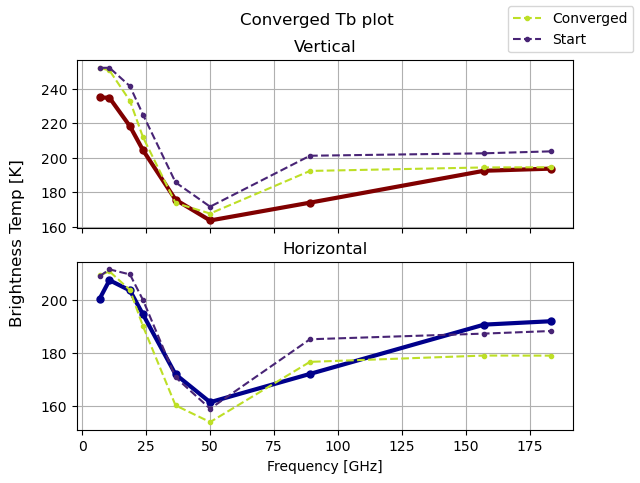

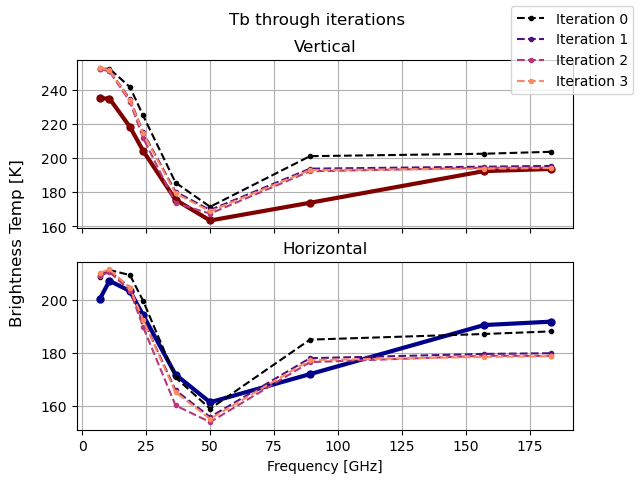

snow thickness    0.805324
ice thickness     0.765574
surf. temp.       0.899820
ACL avg           0.793229
dtype: float64


In [12]:
# Change setting to test different configurations for the uncertainties on the model parameters and
# see how it affects the retrieval
setting = 5


# Depending on the setting, define the free parameters and model parameters that are going to be used
# in the forward model
x_vars = ['snow thickness', 'ice thickness', 'surface temperature', 'ACL avg', 'ACL up']
X_matrix_model_uncertainty = np.copy(X_matrix_used)
x_cov_model_uncertainty = np.cov(X_matrix_model_uncertainty)
logMask = (np.array([1,1,0,1,1]) == 1)
if setting == 1:
    b_vars = [ "ACL_factor_high","ACL_factor_mid","ACL_factor_low","sal_ice_up"]
    b_p = [          0.2,                0.5,             2,             2     ]
    b_cov = (np.array([0.1,              0.1,            0.1,           0.2    ])**2)*np.eye(np.size(b_p))
elif setting == 2:
    b_vars = [ "ACL_factor_mid","ACL_factor_low","sal_ice_up"]
    b_p = [          0.5,             2,              2      ]
    b_cov = (np.array([0.1,          0.1,            0.1     ])**2)*np.eye(np.size(b_p))
elif setting == 3:
    x_vars = ['snow thickness', 'ice thickness', 'surface temperature', 'ACL avg']
    logMask = (np.array([1,1,0,1]) == 1)
    X_matrix_model_uncertainty = np.copy(X_matrix_used[0:4, :])
    x_cov_model_uncertainty = np.cov(X_matrix_model_uncertainty)
    b_vars = [ "ACL_factor_high","ACL_factor_mid","ACL_factor_low","sal_ice_up","snow_density_up"]
    b_p = [          0.2,                0.5,            2,             2,              250      ]
    b_cov = (np.array([0.1,              0.1,            0.1,            0.1,            10      ])**2)*np.eye(np.size(b_p))
elif setting == 4:
    b_vars = [ "ACL_factor_high", "ACL_factor_mid", "ACL_factor_low", "sal_ice_up", "snow_density_up"]
    b_p = [            0.2,              0.5,             2,              2,                 250]
    b_cov = (np.array([0.1,              0.1,            0.1,            0.2,                10])**2)*np.eye(np.size(b_p))
elif setting == 5:
    x_vars = ['snow thickness', 'ice thickness', 'surf. temp.', 'ACL avg']
    logMask = (np.array([1,1,0,1]) == 1)
    X_matrix_model_uncertainty = np.copy(X_matrix_ross[0:4, :])
    x_cov_model_uncertainty = np.cov(X_matrix_model_uncertainty)
    b_vars = []
    b_p = []
    b_cov = [[]]

# Define the model with the correct setting for model uncertainties
def forward(Xb):
    return forwards_FYI.forward_parameterUncertainty(Xb, freqs, m_32_streams, radiometer, logMask=logMask, setting=setting)


# i=[0, 799] is the 1st location for the MEML-simulation
# i=[800, 1599] is the 2nd location. 
# i=[1600, 2399] is the Ross sea. This is only true if X_matrix_used = X_matrix_ross in the 2nd code section.
for i in [1200]:#np.arange(100, 2400, 100):
    print(f"\ni = {i}")
    
    # set a random seed so that answers are reproducible and start a loop timer
    np.random.seed(i)
    start_loop = time.time() # time to see how long each loop will take


    # Load the brightness temperatures we're aiming for in this iteration 
    Tb_goal = np.copy(Y_matrix_ross[:,i]) # can be applied to both the ross and the normal datasets 
    x_true = np.copy(X_matrix_model_uncertainty[:,i])  # can be applied to both the ross and the normal datasets
    x_ap = x_true 

    # Run the optimal estimation
    oe = pyOE.optimalEstimation( 
        x_vars, 
        x_ap, 
        x_cov_model_uncertainty, 
        y_vars, 
        Tb_goal, 
        y_cov, 
        forward,
        b_vars = b_vars,
        b_p = b_p,
        S_b = b_cov,
        x_upperLimit = {"surface temperature": 270},
        convergenceTest='auto'
    ) 
    oe.doRetrieval(maxIter=30)
    
    if oe.converged==True:
        print(f"the autocorrelation length in the layers:\n{np.array([0.2, 0.5, 2])*np.exp(oe.x_op[[-1,-2,-2]])*1e6} micron")
        # parameter plot  through iterations
        

        # Converged Tb plot
        Tb_start = np.array(oe.y_i)[0,:]
        fig, ax = plt.subplots(nrows=2, sharex=True)
        ax[0].plot(freqs*1e-9, Tb_goal[::2], '.-', color='Maroon', linewidth=3, markersize=10)
        ax[1].plot(freqs*1e-9, Tb_goal[1::2], '.-', color='DarkBlue', linewidth=3, markersize=10)
        ax[0].grid(); ax[1].grid()
        ax[1].set_xlabel('Frequency [GHz]')
        fig.supylabel('Brightness Temp [K]')
        viridis = cm.get_cmap('viridis')
        Tb_model_new = oe.y_op
        ax[0].plot(freqs*1e-9, Tb_model_new[::2], '.--',  color=viridis(0.9), label='Converged')
        ax[1].plot(freqs*1e-9, Tb_model_new[1::2], '.--', color=viridis(0.9))
        ax[0].plot(freqs*1e-9, Tb_start[::2], '.--',  color=viridis(0.1), label='Start')
        ax[1].plot(freqs*1e-9, Tb_start[1::2], '.--', color=viridis(0.1))
        ax[0].set_title('Vertical')
        ax[1].set_title('Horizontal')
        fig.legend()
        fig.suptitle('Converged Tb plot')

        
        # Tb plot through iterations
        Tb_iterations = np.array(oe.y_i)
        fig, ax = plt.subplots(nrows=2, sharex=True)
        ax[0].plot(freqs*1e-9, Tb_goal[::2], '.-', color='Maroon', linewidth=3, markersize=10)
        ax[1].plot(freqs*1e-9, Tb_goal[1::2], '.-', color='DarkBlue', linewidth=3, markersize=10)
        ax[0].grid(); ax[1].grid()
        ax[1].set_xlabel('Frequency [GHz]')
        fig.supylabel('Brightness Temp [K]')
        magma = cm.get_cmap('magma') # Good cmaps: hot, viridis, plasma, magma. In general: Perceptually Uniform Sequential Colormaps are good.
        for j in range(Tb_iterations.shape[0]):
            Tb_model_new = Tb_iterations[j,:]
            ax[0].plot(freqs*1e-9, Tb_model_new[::2], '.--',  color=magma(j/Tb_iterations.shape[0]), label=f"Iteration {j}")
            ax[1].plot(freqs*1e-9, Tb_model_new[1::2], '.--', color=magma(j/Tb_iterations.shape[0]))
        fig.legend()
        ax[0].set_title('Vertical')
        ax[1].set_title('Horizontal')
        fig.suptitle('Tb through iterations')
        plt.show()
        
        
        print(oe.dgf_x)

In [9]:
67.74/32.21 # (setting 5) / (setting 3) at i=225 

2.1030735796336537

In [10]:
143.82/71.78 # (setting 5) / (setting 3) at i=300

2.003622178879911